# Generative Learning Using a Quantum Computer

In this tutorial, we implement Data-driven quantum circuit learning (DDQCL), based on the 2019 paper [Training of quantum circuits on a hybrid quantum computer](https://advances.sciencemag.org/content/5/10/eaaw9918) by Zhu et. al.

### DQCCL
DDQCL is a hybrid quantum-classical technique for generative modeling of classical data, using a parametrized quantum circuit as the model being trained. Training occurs by sampling the output of a parametrized circuit run on a quantum computer and updating the circuit parameters using classical optimization techniques. Convergence produces a circuit that captures the correlations in the training data, thus serving as a generative model for the data itself.

### The Bars-And-Stripes (BAS) Dataset
The data we will be training against is a canonical ensemble that works like so: for an $n \times m$ matrix, each cell can either be on (filled-in) or off (blank); in this example, we consider it a valid BAS example if it contains only a single completely filled row (bars) or column (stripes). 

For a 2x2 matrix, like we will be using in this example, this allows for four valid patterns of 16 total permutations:

['■ ', '■ ']
['□ ', '□ ']

['□ ', '□ ']
['■ ', '■ ']

['■ ', '□ ']
['■ ', '□ ']

['□ ', '■ ']
['□ ', '■ ']


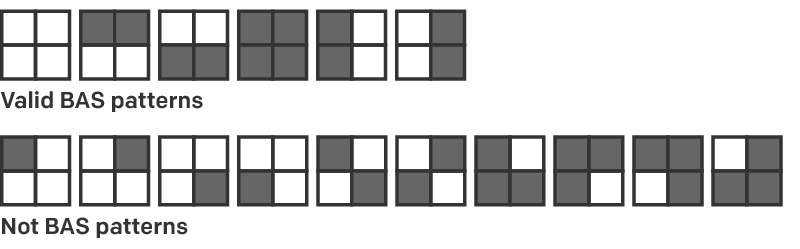

In [1]:
['■ ', '■ ']
['□ ', '□ ']

['□ ', '□ ']
['■ ', '■ ']

['■ ', '□ ']
['■ ', '□ ']

['□ ', '■ ']
['□ ', '■ ']

['□ ', '■ ']

We encode this as a binary string by reading left-to-right, top-to-bottom, with a filled-in cell representing a 1 and a blank cell a 0; the above valid examples translate (in order) to 1100, 0011, 1010, and 0101.

## Implementation
We will be implementing this technique using noisyopt, a python library for optimizing noisy functions. To do that, we'll need to define
1. A generator for our BAS training data
2. A generator for our parametrized circuit
3. A cost function for our optimizer
4. Methods for running circuits on the Azure IonQ backend
5. The hybrid learning algorithm itself, using all of the above

## Imports and Setup

First, we'll do some setup that will allow us to build, optimize, visualize, store, and retrieve the circuits we'll be running via Azure.

In [2]:
# general imports
import math
import time
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
import string

# Noisy optimization package — you could also use scipy's optimization functions, 
# but this is a little better suited to the noisy output of NISQ devices.
%pip install noisyopt
import noisyopt

# magic invocation for producing visualizations in notebook
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pkgs.dev.azure.com/ms-quantum-public/9af4e09e-a436-4aca-9559-2094cfe8d80c/_packaging/alpha/pypi/simple/
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import qsharp routines and connect to azure workspace
import qsharp
import qsharp.azure
from Cost import AllocateQubitsandRunCircuit
# Uncomment line below with your resource id
#qsharp.azure.connect(resourceId='MyId') 

In [4]:
# fix random seed for reproducibility — this allows us to re-run the process and get the same results
seed = 42
np.random.seed(seed)
random.seed(a=seed)

## BAS Generator

Here we generate our bars and stripes — as this is just a proof-of-principle, we are limiting the possible outputs to the four single-bar or single-stripe outputs to keep convergence time (and therefore training cost) low.

In [5]:
#Generate BAS, only one bar or stripe allowed
def generate_target_distribution(rows, columns):        
    #Stripes
    states=[]
    for i in range(rows):
        s=['0']*rows*columns
        for j in range(columns):
            s[j+columns*i]='1'
        states.append(''.join(s))
                
        
    #Bars
    for j in range(columns):
        s=['0']*rows*columns
        for i in range(rows):
            s[j+columns*i]='1'
        states.append(''.join(s))
    print(states)
    return states

## Circuit Generator

Here we define several driver functions which consist of parametrized one qubit gates that help to explore the Hilbert space, and several entangler functions that generate entanglement in the system. 

The complete circuit ansatz consists of repeating layers of the drivers and entanglers. The parameters ($\gamma$ and $\beta$) of the ansatz are iteratively optimized (learned) by our hybrid quantum-clasical routine.

In [6]:
#Parameters for driver
def generate_beta(random_init, n,layers):
    
    beta=(
        [random.uniform(0.0,2.*math.pi) for i in range(3*n*(layers-1))] 
        if random_init 
        else [0]*3*n*(layers-1)
    )
            
    return beta

#Parameters for entangler
def generate_gamma(random_init, n, conn,layers):
    length_gamma=int(n*conn-conn*(conn+1)/2.)
    gamma=(
        [random.uniform(0.0,2.*math.pi) for i in range(length_gamma*layers)]
        if random_init
        else [0]*length_gamma*layers
    )
            
    return gamma



## Cost function

Here, we define our cost function to feed to the optimization routine, which takes the form of a regularized Kullback-Leibler Divergence ([Quick Overview](https://medium.com/@cdefaux/kullback-leibler-divergence-for-dummies-c3613bc80ad3), [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)).

In [9]:
def cost(prob_hist, target_states,tol=0.0001):
    cost=0
    for state in target_states:        
        if state in prob_hist:
            cost-=1./len(target_states)*np.log2(max(tol,prob_hist[state]))
        else:
            cost-=1./len(target_states)*np.log2(tol)
    
    return cost

## Helper Methods

Finally, we define two helper methods: `run_iteration`, to run and return each iteration of our circuit (with some helpful tools for managing timeouts and waiting for results) and `run_circuit_and_calc_cost`, which  uses `run_iteration` to both run an interation of the circuit and calculate a new cost function, effectively taking a training step.

In [15]:
def run_iteration(params, n, conn, layers, shots): 
    n, conn, layers, target_states, shots = args

    # submit task: define task (asynchronous)
    task_status=''
    while task_status != 'Succeeded':
        task = qsharp.azure.submit(AllocateQubitsandRunCircuit, n=n, parameters=params, conn=conn, layers=layers, shots=shots)        
   
        # Get ID of submitted task
        task_id = task.id
        #print('Task ID :', task_id)

        task_status=qsharp.azure.status(task_id).status
        while (task_status == 'Waiting') or (task_status == 'Finishing') or (task_status == 'Executing'):
            time.sleep(1)
            task_status=qsharp.azure.status(task_id).status
        
        print('Task status is', task_status)

    # get result
    result = qsharp.azure.output(task_id)
    result_bits={}
    for state in result:
        state_bits=state.strip("[]").replace(',','')
        result_bits[state_bits]=result[state]

    return result_bits

#Run an iteration of the circuit and calculate its cost
def run_circuit_and_calc_cost(params, *args):
    n, conn, layers, target_states, shots = args
    result=run_iteration(params, n, conn, layers, shots)   
    cost_run = cost(result, target_states)
    print(cost_run)
    return cost_run

# Running The Learning Algorithm

Now we're ready to run the learning algorithm and train our circuit.

### Set Up Training Data

First, we'll set up our training data for the problem using the method we defined earlier.

In [11]:
#Set problem parameters
r=2 #Number of rows — make sure r*c is less than qubit count
c=2 #Number of columns — make sure r*c is less than qubit count
n=r*c #Qubits needed
conn=2 #Connectivity of the entangler.

#Check on conn
if conn>(n-1):
    raise Exception("Connectivity is too large")
    
target_states=generate_target_distribution(r,c)

# Check expected output
print('Bitstrings that should be generated by trained circuit are', target_states, 'corresponding to the following BAS patterns:\n')
for state in target_states:
    #bitstring = bin(state)[2:].zfill(n)
    #print(bitstring)
    #print(state, "({})".format(bitstring))
    for i in range(r):
        state_2d=state[c*i:][:c]
        state_2d=['□ ' if x=='0' else '■ ' for x in state_2d]
        print(state_2d)
        #print(bitstring[c*i:][:c].replace('0','□ ').replace('1','■ '))
    print('')

['1100', '0011', '1010', '0101']
Bitstrings that should be generated by trained circuit are ['1100', '0011', '1010', '0101'] corresponding to the following BAS patterns:

['■ ', '■ ']
['□ ', '□ ']

['□ ', '□ ']
['■ ', '■ ']

['■ ', '□ ']
['■ ', '□ ']

['□ ', '■ ']
['□ ', '■ ']



### Choose Target Device

We need to do this first because we check against its capabilities when building the training data and circuit. We do not recommend running this this algorithm against a real hardware device until you have run it on a simulator to understand estimated price and if it will converge with the parameters you've selected.

In [12]:
qsharp.azure.target("ionq.simulator")

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.simulator


{'id': 'ionq.simulator', 'current_availability': 'Available', 'average_queue_time': 0}

### Set Up Training Parameters
Now, we'll set up our parameters for the training routine itself — these are all tunable; feel free to play with them to see how they impact the routine (especially when running on a local simulator!). Again, because this is just a proof-of-principle demo, we've selected some defaults that keep convergence time and training cost low.

In [13]:
# Choose entangler and driver type
layers=1 # Number of layers in each circuit
shots=1000 # Number of shots per iteration
random_init=False # Set to true for random initialization; will be slower to converge

# Set up args
beta=generate_beta(random_init, n, layers)
gamma=generate_gamma(random_init, n, conn, layers)
params=beta+gamma

base_bounds=(0,2.*math.pi)
bnds=((base_bounds , ) * len(params)) 

max_iter=10 # max number of optimizer iterations

args=(n, conn, layers, target_states, shots)


Submitting Cost.AllocateQubitsandRunCircuit to target ionq.simulator...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 913e9922-8099-4677-881f-97340278063f
Task status is Succeeded
13.287712379549449
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.simulator...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 56f9a07c-b04c-4b7a-94a5-481ebeb8dbeb
Task status is Failed
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.simulator...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 75ed2a5c-cdf4-434c-854f-6f135981a651
Task status is Succeeded
4.274351649294314
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.simulator...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: fa4b1cf8-4db2-4643-a41f-1de613b2c9bf
Task status is Succeeded
7.960304565552633
Submitting C

<BarContainer object of 16 artists>

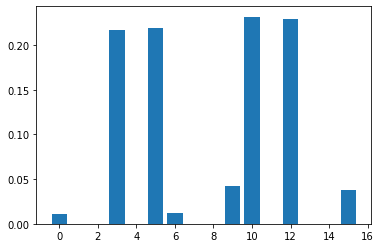

In [11]:
#Train Circuit on simulator
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))

#Plot output
result_hist=run_iteration(result.x, n, conn, layers, shots)
full_hist=[0]*(2**n)
for state in result_hist:
    state_int=int(state, 2)
    full_hist[state_int]=result_hist[state]
plt.figure()
plt.bar(range(2**n),full_hist)

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.qpu...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 4c8bdf3f-6265-4820-94d0-5e6c57b23162
Task status is Failed
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.qpu...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 5acab038-ffde-4446-83e1-08d1448b246d
Task status is Succeeded
3.856360043311813
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.qpu...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: aa170fa0-c3db-4ee6-9b85-64d3b22fb8df
Task status is Succeeded
9.734284430023031
Submitting Cost.AllocateQubitsandRunCircuit to target ionq.qpu...
Job successfully submitted for 1000 shots.
   Job name: Cost.AllocateQubitsandRunCircuit
   Job ID: 725a4f4e-9c37-4516

<BarContainer object of 16 artists>

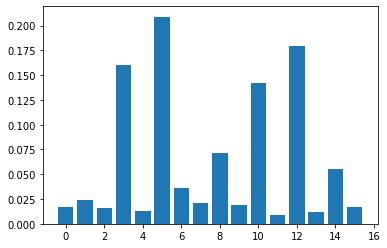

In [16]:
#Train Circuit on qpu
qsharp.azure.target("ionq.qpu")
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))

#Plot output
result_hist=run_iteration(result.x, n, conn, layers, shots)
full_hist=[0]*(2**n)
for state in result_hist:
    state_int=int(state, 2)
    full_hist[state_int]=result_hist[state]
plt.figure()
plt.bar(range(2**n),full_hist)